### 지금까지 했던 것 총정리

In [7361]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import shapiro

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler

import datetime

### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def calculate_mdd(cumulative_returns):
    """
    Maximum Drawdown (MDD) 계산 함수
    :param cumulative_returns: 누적 수익률 (1 + 전략 수익률).cumprod() 형태의 데이터
    :return: MDD (최대 낙폭)
    """
    peak = np.maximum.accumulate(cumulative_returns)  # 최고점 누적 기록
    drawdown = (cumulative_returns - peak) / peak  # 각 시점의 손실 비율
    mdd = drawdown.min()  # 최대 손실율 (음수 값)
    return mdd


def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

### 데이터 세팅

In [7362]:
### 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")

### target df 읽기
columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_threshold_1000_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_receive.csv")
target_event_send_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_send.csv")

target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_send_df = preprocess_transaction_flag(target_event_send_df)

target_event_receive_df.columns = columns
target_event_send_df.columns = columns

### target difference df
target_event_difference_df = target_event_receive_df.copy()
target_event_difference_df['transaction_count'] = (target_event_receive_df['transaction_count'] - target_event_send_df['transaction_count'])
target_event_difference_df['transaction_amount'] = (target_event_receive_df['transaction_amount'] - target_event_send_df['transaction_amount'])
target_event_difference_df['transaction_flag'] = target_event_difference_df['transaction_amount'].apply(
    lambda x: 1 if x > 0 else (0 if x == 0 else -1)
)

### 날짜에 맞춰 자르기
start = (test_df['date'].values)[0]
end = (test_df['date'].values)[-1]

target_event_receive_df = trim_date(target_event_receive_df, start, end)
target_event_send_df = trim_date(target_event_send_df, start, end)
target_event_difference_df = trim_date(target_event_difference_df, start, end)

test_df.set_index('date', inplace=True)



### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'

event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)
test_df['big_returns_flag'] = test_df['returns'].abs()>0.05
# test_df['lag_event_flag'] = test_df['event_flag'].shift(-2).fillna(0)
event_flag_copy = test_df['event_flag'].values
big_returns_flag_copy = test_df['big_returns_flag'].values

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

### 회귀분석 돌릴때 Cheating 방지용으로 transaction 관련 target값 삭제
transaction_count = test_df['transaction_count'].copy()
transaction_amount = test_df['transaction_amount'].copy()
transaction_amount_usd = test_df['transaction_amount_usd'].copy()

### 수익률 관련 변수
returns_copy = test_df['returns'].copy()
test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())
during_2day_copy = test_df['returns_during_2day'].values


##### 전처리 관련
### 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)

### NaN값 처리 방법
test_df = test_df.fillna(test_df.mean())

### test_df 나중 분석을 위해 따로 저장
test_copy_df = test_df.copy()

### 스케일링
scaler = StandardScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

test_df = test_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag', 'transaction_amount_usd'], axis=1)

# test_df['target_delta'] = test_df['target'].diff(1)

### 스케일링 유의 변수
test_df['returns'] = returns_copy
test_df['returns_during_2day'] = during_2day_copy
test_df['event_flag'] = event_flag_copy
test_df['big_returns_flag'] = big_returns_flag_copy

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\2120250651.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)
C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\2120250651.py:98: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())


<Axes: xlabel='date'>

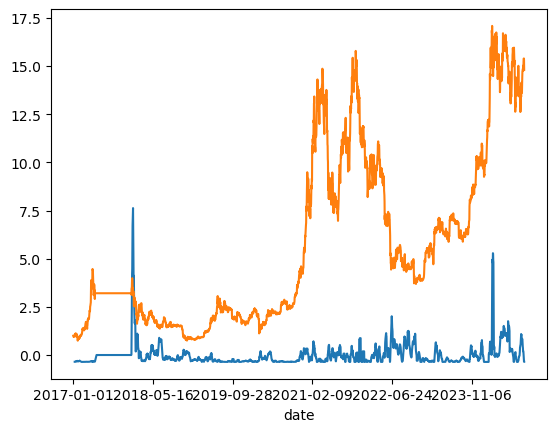

In [7363]:
### 스케일링
scaler = StandardScaler()
(pd.DataFrame(scaler.fit_transform(test_copy_df), columns=test_copy_df.columns, index=test_copy_df.index)['target']).rolling(10).mean().plot()

(1+test_copy_df['returns']).cumprod().plot()

In [7364]:
test_copy_df[['returns', 'transaction_amount', 'target', 'target_delta', 'target_returns', 'vpin']].describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
returns,2830.0,1.612090e-03,3.607990e-02,-3.950485e-01,-9.999244e-02,-1.227509e-02,0.000000e+00,1.529362e-02,1.063411e-01,2.250139e-01
transaction_amount,2830.0,1.851405e+05,9.541025e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,1.285258e+05,2.228565e+06,2.491523e+07
target,2830.0,1.823643e+09,5.089270e+09,1.000000e-10,1.000000e-10,1.000000e-10,2.242831e+08,1.823643e+09,1.598677e+10,1.066540e+11
target_delta,2830.0,-1.511529e+06,4.740623e+09,-5.895144e+10,-9.631444e+09,-1.964618e+08,0.000000e+00,8.958915e+07,1.046060e+10,6.482819e+10
target_returns,2830.0,2.304158e+18,1.682938e+19,-1.000000e+00,-1.000000e+00,-2.498244e-01,0.000000e+00,2.406381e-01,5.823788e+19,5.895144e+20
vpin,2830.0,6.453470e-01,6.112185e-02,9.000000e-04,4.836492e-01,6.098612e-01,6.482219e-01,6.859938e-01,7.729164e-01,8.470440e-01


In [7365]:
test_df['event_flag']

date
2017-01-01    0.0
2017-01-02    0.0
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
             ... 
2024-09-26    0.0
2024-09-27    0.0
2024-09-28    0.0
2024-09-29    0.0
2024-09-30    0.0
Name: event_flag, Length: 2830, dtype: float64

In [7366]:
pd.set_option('display.max_columns', None)

test_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,event_flag,big_returns_flag,target,target_delta,target_returns,vpin,vpin_ma_10,returns_during_2day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,-1.111536,0.000000,-0.880727,-1.112165,-1.107929,-1.107056,-0.752190,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.000000,-1.384638e-16,-1.385767e-16,0.000000,-1.318389e-16,6.953688e-16,0.000000,3.645692e-16,0.000000,0.000000,1.936683e-16,0.000000,0.000000,1.652036e-16,0.000000,-5.403927e-16,2.357973e-16,-5.153963e-16,0.000000,-4.867979e-16,-5.204247e-16,-1.099428e-15,-1.524501e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,False,-0.349973,-5.403487e-19,-1.521418e-17,1.169821,-0.006735,-0.033862
2017-01-02,-0.041238,-1.121003,0.653487,-0.875523,-1.110900,-1.113896,-1.121457,-0.640992,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.000000,-1.384638e-16,-1.385767e-16,0.000000,-1.318389e-16,-8.700713e-01,-1.572275,-8.474623e-01,-1.315835,-1.010971,-1.097035e+00,1.558431,-0.527752,-1.004574e+00,-1.187699,5.654632e-02,-1.371472e+00,-2.384392e-01,-0.469625,-1.648762e+00,-2.587986e-01,-7.066792e-01,-1.715789e-01,-0.862324,-0.450657,0.238978,0.000000,0.000000,0.000000,0.0,False,-0.358394,-8.721760e-03,-1.369370e-01,0.463199,-0.006735,-0.005374
2017-01-03,0.007694,-1.119310,-0.554939,-0.886047,-1.120372,-1.123688,-1.126337,-0.714619,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.000000,-1.384638e-16,-1.385767e-16,0.000000,-1.318389e-16,-9.900269e-01,-1.571226,-1.022963e+00,-1.314618,-1.010971,-1.046857e+00,2.376360,-0.527185,-1.004224e+00,-1.186651,8.272219e-01,-1.364727e+00,-1.502490e-01,-0.457000,-1.647571e+00,-1.630155e-01,-8.453647e-01,7.497004e-02,-0.858258,-0.448662,0.276395,0.000000,0.000000,0.000000,0.0,False,-0.358394,3.189024e-04,-1.369370e-01,0.073948,-0.006735,-0.029947
2017-01-04,-0.012969,-1.122186,-0.364922,-0.884944,-1.118678,-1.122305,-1.116298,-0.831921,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.

### 기본적인 통계, 시계열 분석

In [7367]:
stats_df = test_df.copy()

print(stats_df[['target', 'target_delta', 'target_returns']].describe())

stats_df.index = pd.to_datetime(stats_df.index)

# 연도별 event_flag 개수 확인
event_count_per_year = stats_df.groupby(stats_df.index.year)['event_flag'].sum()

# 결과 출력
print(event_count_per_year)


             target  target_delta  target_returns
count  2.830000e+03  2.830000e+03    2.830000e+03
mean   1.004301e-17  1.726142e-18   -1.506451e-17
std    1.000177e+00  1.000177e+00    1.000177e+00
min   -3.583943e-01 -1.243726e+01   -1.369370e-01
25%   -3.583943e-01 -4.113060e-02   -1.369370e-01
50%   -3.143167e-01  3.189024e-04   -1.369370e-01
75%    4.685558e-17  1.922042e-02   -1.369370e-01
max    2.060195e+01  1.367777e+01    3.489814e+01
date
2017    2.0
2018    8.0
2019    1.0
2020    0.0
2021    6.0
2022    9.0
2023    1.0
2024    0.0
Name: event_flag, dtype: float64


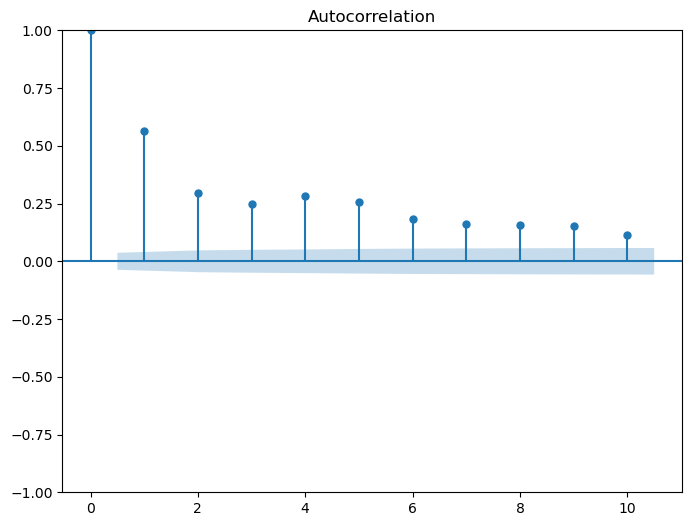

[[1.         0.86967513]
 [0.86967513 1.        ]]


In [7368]:
### target 값의 autocorrelation
sm.tsa.stattools.acf(test_df['target'], nlags=10, fft=False)

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(test_df['target'], lags=10, ax=ax)
plt.show()


### Transaction Amount, Transaction Count 사이 상관관계
print(np.corrcoef([transaction_amount, transaction_count]))

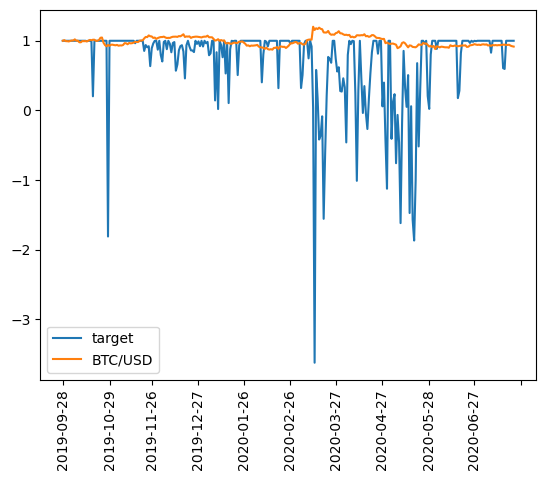

In [7369]:
### target값과 가격 그래프
plot_df = test_df.iloc[1000:1300, :]
plt.plot(plot_df['target']/plot_df['target'].iloc[0], label='target')
plt.plot(plot_df['close']/plot_df['close'].iloc[0], label='BTC/USD')
plt.xticks(rotation=90)
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

plt.show()

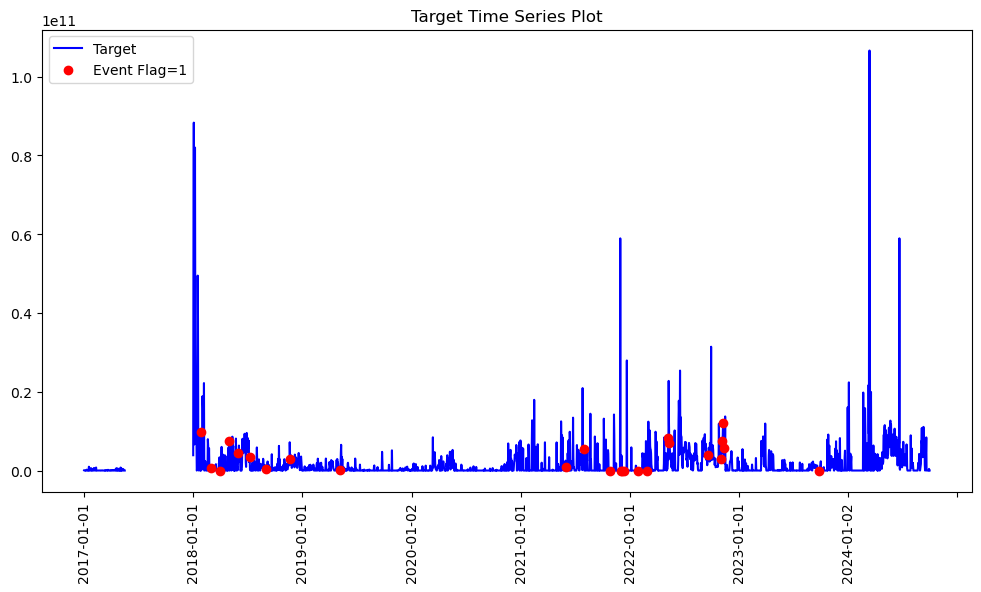

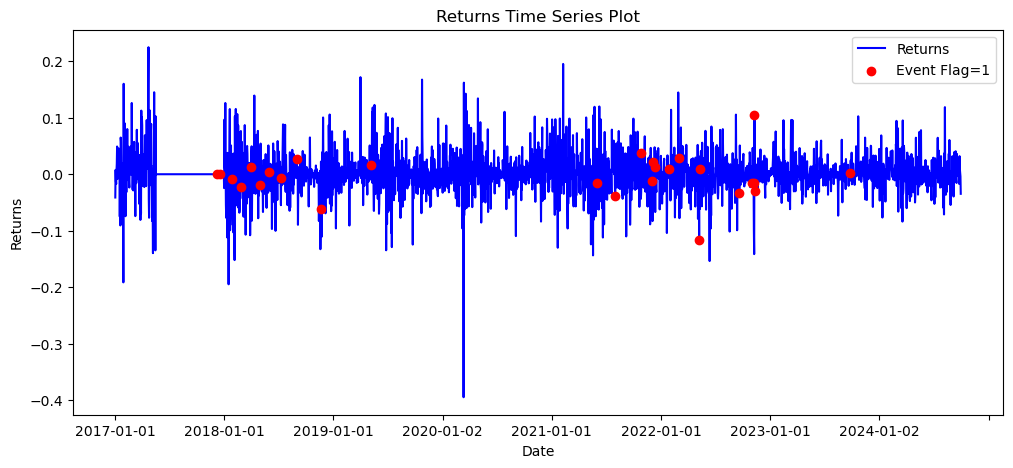

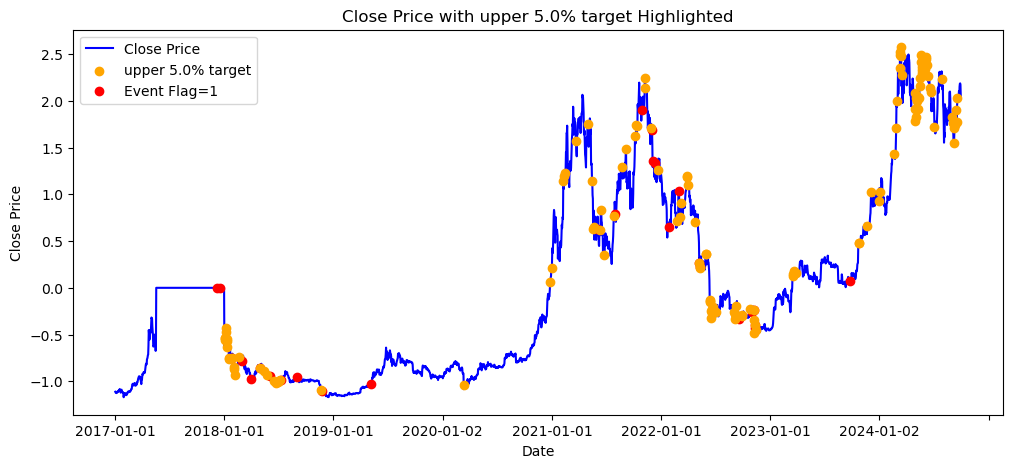

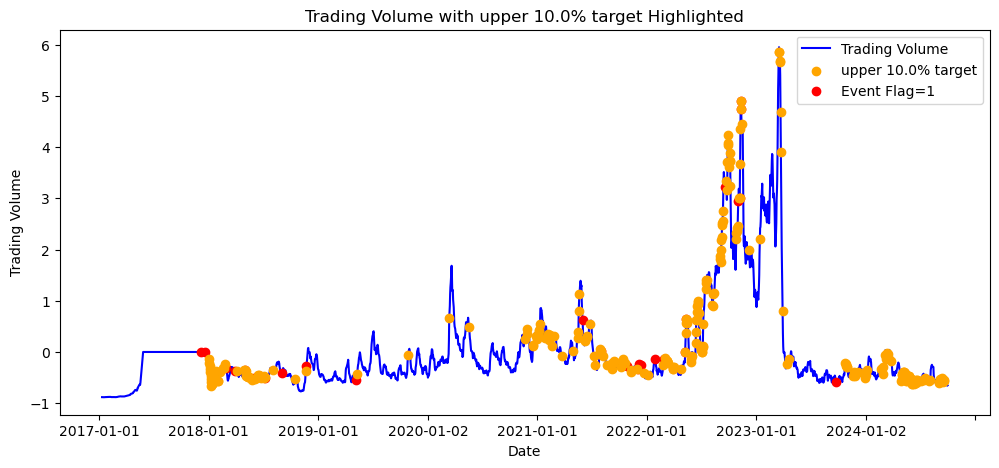

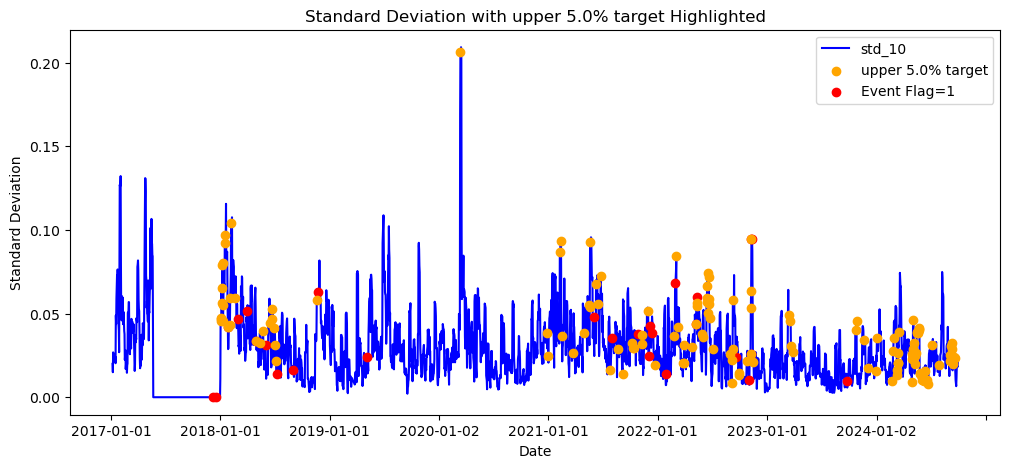

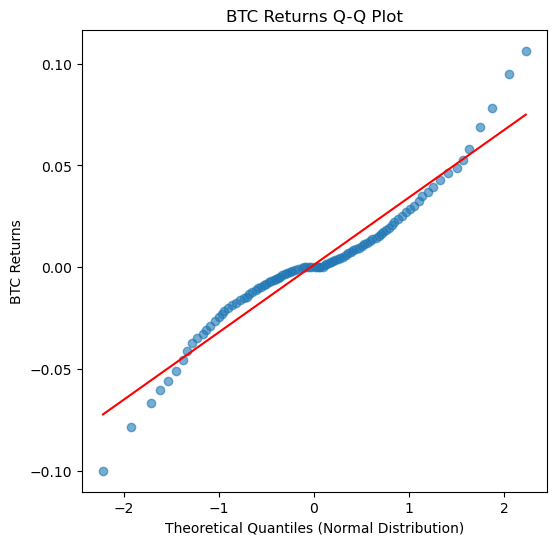

In [7370]:
# 데이터 복사 및 이벤트 플래그 추가
transaction_amount_usd_plot = transaction_amount_usd.copy().to_frame()
transaction_amount_usd_plot['event_flag'] = test_df['event_flag']
# transaction_amount_usd_plot['event_flag'] = test_df['big_returns_flag']

# # 날짜별 데이터 필터링
start_date = '2017-01-01'
end_date = '2024-12-31'

transaction_amount_usd_plot = transaction_amount_usd_plot[(transaction_amount_usd_plot.index >= start_date)&(transaction_amount_usd_plot.index <= end_date)]

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = transaction_amount_usd_plot[transaction_amount_usd_plot['event_flag'] == 1].index
event_values = transaction_amount_usd_plot.loc[event_indices, transaction_amount_usd_plot.columns[0]]  # target 값

# 타임 시리즈 그래프
plt.figure(figsize=(12, 6))
plt.plot(transaction_amount_usd_plot.iloc[:, 0], label='Target', color='blue')  # 첫 번째 컬럼이 target 값
plt.scatter(event_indices, event_values, color='red', label="Event Flag=1", zorder=3)  # 이벤트 발생 시점 표시

plt.xticks(rotation=90)
plt.title("Target Time Series Plot")
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()

############
### 수익률 Time Series Plot
plt.figure(figsize=(12, 5))
returns_plot = test_df[(test_df.index >= start_date)&(test_df.index <= end_date)].copy()
plt.plot(returns_plot.index, returns_plot['returns'], label="Returns", color='blue')

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = returns_plot[returns_plot['event_flag'] == 1].index
event_values = returns_plot.loc[event_indices, returns_plot.columns[0]]  # target 값
plt.scatter(event_indices, event_values, color='red', label="Event Flag=1", zorder=3)  # 이벤트 발생 시점 표시
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Returns Time Series Plot")
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()
#############

########################
## 가격
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
price_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()

# Price 시계열 그래프
plt.plot(price_plot.index, price_plot['close'], label="Close Price", color='blue')

# 인덱스 필터링 조건 설정
top = 0.05
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = price_plot[target].quantile(1-top)
lower_threshold = price_plot[target].quantile(top)
if condition == 'upper':
    event_indices = price_plot[price_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = price_plot[price_plot[target] <= lower_threshold].index
event_values = price_plot.loc[event_indices, 'close']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = price_plot[price_plot['event_flag'] == 1].index
event_values = price_plot.loc[event_indices, 'close']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f'Close Price with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############



########################
## Volume 시계열 확인
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
volume_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()
volume_plot['ma_10'] = volume_plot['volume'].rolling(10).mean()

# Volume 시계열 그래프
plt.plot(volume_plot.index, volume_plot['ma_10'], label="Trading Volume", color='blue')

# 인덱스 필터링 조건 설정
top = 0.1
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = volume_plot[target].quantile(1-top)
lower_threshold = volume_plot[target].quantile(top)
if condition == 'upper':
    event_indices = volume_plot[volume_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = volume_plot[volume_plot[target] <= lower_threshold].index
event_values = volume_plot.loc[event_indices, 'ma_10']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = volume_plot[volume_plot['event_flag'] == 1].index
event_values = volume_plot.loc[event_indices, 'ma_10']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title(f'Trading Volume with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############


########################
## Std 시계열 확인
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
std_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()
std_plot['std_10'] = std_plot['returns'].rolling(5).std()

# 'std_10' 시계열 그래프
plt.plot(std_plot.index, std_plot['std_10'], label='std_10', color='blue')

# 인덱스 필터링 조건 설정
top = 0.05
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = std_plot[target].quantile(1-top)
lower_threshold = std_plot[target].quantile(top)
if condition == 'upper':
    event_indices = std_plot[std_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = std_plot[std_plot[target] <= lower_threshold].index
event_values = std_plot.loc[event_indices, 'std_10']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = std_plot[std_plot['event_flag'] == 1].index
event_values = std_plot.loc[event_indices, 'std_10']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.title(f'Standard Deviation with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############




###############
### 비트코인 Returns의 Q-Q Plot
normal_dist = lambda l : np.random.standard_normal(l)

btc_ret = test_df['returns']

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

btc_q = btc_ret.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(btc_ret)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, btc_q, alpha=0.6)

x, y = nd_q, btc_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('BTC Returns')
plt.title('BTC Returns Q-Q Plot')

plt.show()

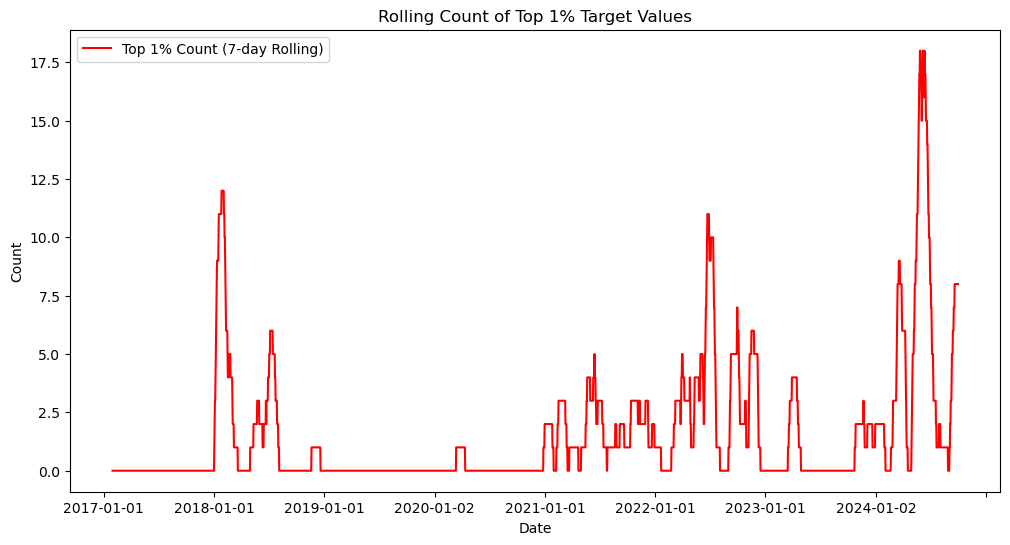

In [7371]:
# 상위 1% 필터링
top_1_threshold = price_plot['target'].quantile(0.95)
price_plot['top_1_flag'] = (price_plot['target'] >= top_1_threshold).astype(int)

# 상위 1% 값 플래그 추가
price_plot['top_1_flag'] = (price_plot['target'] >= top_1_threshold).astype(int)

# 롤링 카운트
price_plot['rolling_count'] = price_plot['top_1_flag'].rolling(window=30).sum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(price_plot.index, price_plot['rolling_count'], label='Top 1% Count (7-day Rolling)', color='red')
plt.title("Rolling Count of Top 1% Target Values")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()


In [7372]:
lagged_event_df = test_copy_df.copy()
lagged_event_df['transaction_flag'].value_counts()

transaction_flag
1    1572
0    1258
Name: count, dtype: int64

In [7373]:
lagged_event_df = test_copy_df.copy()
lagged_event_df['lagged_event_flag'] = lagged_event_df['event_flag'].shift(-1).fillna(0)
lagged_event_df[lagged_event_df['lagged_event_flag']==1]['transaction_flag'].value_counts()

transaction_flag
1    19
0     8
Name: count, dtype: int64

### Target의 Returns예측

In [7374]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume']].fillna(test_df.mean())


# # train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2017-01-01'
end = '2018-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_test['vpin'] = test_df['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())


=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.888
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.130
Time:                        20:57:21   Log-Likelihood:                 1321.1
No. Observations:                 730   AIC:                            -2634.
Df Residuals:                     726   BIC:                            -2616.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\705676725.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['vpin'] = test_df['vpin']


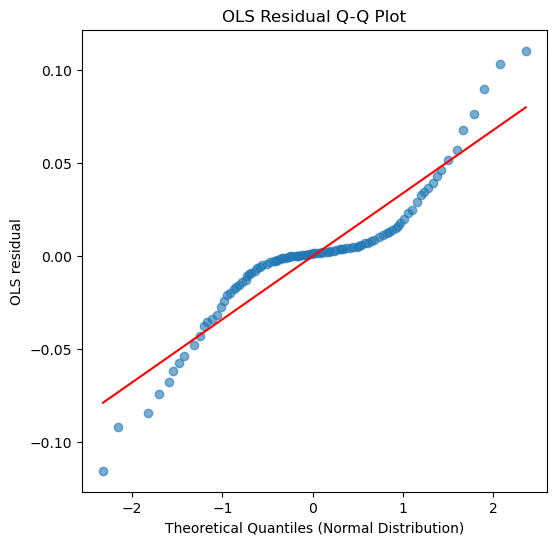

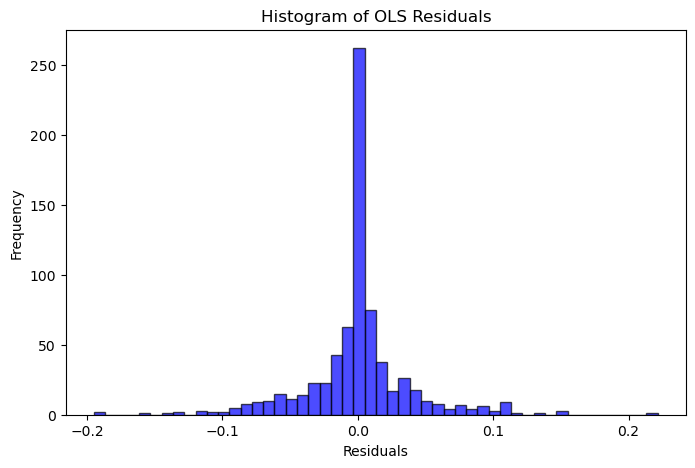

In [7375]:
### OLS Residual의 Q-Q Plot (정규성 확인)

normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')
plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of OLS Residuals")
plt.show()

### Event Flag를 더미변수로 추가하면 기울기가 늘어나는지

In [7376]:
# 파생변수 추가
test_df['event_target'] = test_df['target'] * test_df['event_flag'].shift(-2).fillna(test_df['event_flag'].mean())

# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume', 'event_flag']].fillna(test_df.mean())

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2023-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())


from scipy.stats import shapiro

stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")



from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(lr.resid, lr.model.exog)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     195.3
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           1.04e-89
Time:                        20:57:21   Log-Likelihood:                 1445.2
No. Observations:                 639   AIC:                            -2882.
Df Residuals:                     635   BIC:                            -2864.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

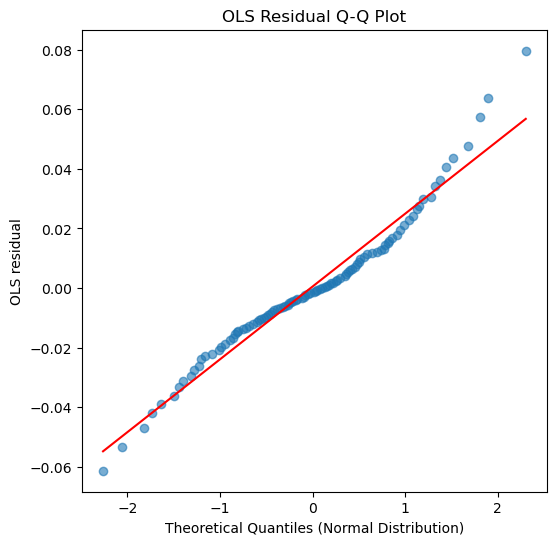

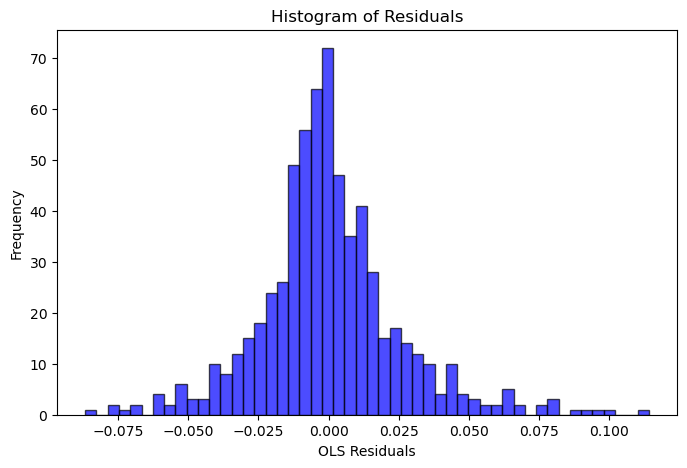

Shapiro-Wilk Test Statistic: 0.9551513805864323, p-value: 4.898704782108961e-13
Jarque-Bera Test Statistic: 187.02883718018873, p-value: 2.438956350650807e-41
Residual Variance: 0.0006355374088497729
Residual Standard Deviation: 0.025209867291395505


In [7377]:
### OLS Residual의 Q-Q Plot (정규성 확인)
normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')

plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("OLS Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


### 샤피로 테스트 (정규성 검정)
stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

### jarque bera (왜도, 첨도 검정)
jb_stat, jb_pvalue, _, _ = jarque_bera(lr.resid)
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_pvalue}")

### Variance, Standard Deviation
print(f"Residual Variance: {np.var(lr.resid)}")
print(f"Residual Standard Deviation: {np.std(lr.resid)}")



### XGBoost 학습 (독립변수: Transaction Amount, 종속변수: BTC Returns)

In [7378]:


model_xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, reg_lambda=1, reg_alpha=0.5)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print(f"XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb)}")


# Train MSE vs Test MSE 비교
y_train_pred = model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_pred_xgb)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


XGBoost MSE: 0.0006661395880205458
Train MSE: 0.0014777787004945622
Test MSE: 0.0006661395880205458


### Target 값이 변동성을 유의미하게 설명하는지

In [7379]:
test_df['volatility'] = test_df['returns']**2

# Independent, Dependent 분리
y = test_df['volatility'].shift(-2).fillna(test_df['volatility'].mean())
X = test_df[['target', 'volume', 'event_flag']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2017-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_test['vpin'] = test_df['vpin']

X_with_const = sm.add_constant(X_test)


# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.386
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.236
Time:                        20:57:21   Log-Likelihood:                 11413.
No. Observations:                2830   AIC:                        -2.282e+04
Df Residuals:                    2825   BIC:                        -2.279e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### VIF: Volume과 Target Delta 사이 설명력 중복 확인

In [7380]:

# Target Delta를 적절히 Lagging
test_df['lag_target_delta'] = test_df['target_delta'].shift(1)

# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['lag_target_delta', 'target', 'volume']].fillna(test_df.mean())


X['returns'] = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)

start = '2023-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]


print(X_test[['returns', 'lag_target_delta', 'target', 'volume']].corr())  # 상관관계 확인

# VIF 계산
X = X[['lag_target_delta', 'target', 'volume']]  # OLS 모델에서 사용한 독립변수들
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_test.columns
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

print(vif_data)



                   returns  lag_target_delta    target    volume
returns           1.000000          0.028948 -0.103140  0.101290
lag_target_delta  0.028948          1.000000  0.328641  0.011174
target           -0.103140          0.328641  1.000000 -0.053588
volume            0.101290          0.011174 -0.053588  1.000000
            Feature       VIF
0  lag_target_delta  1.064890
1            target  1.075890
2            volume  1.011031


### Target의 변화값이 Returns를 유의미하게 설명하는지

In [7381]:
# Target Delta를 적절히 Lagging
test_df['lag_target_delta'] = test_df['target_returns'].shift(0)

# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['lag_target_delta']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2023-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
# lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.07572
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.927
Time:                        20:57:22   Log-Likelihood:                 1438.4
No. Observations:                 639   AIC:                            -2871.
Df Residuals:                     636   BIC:                            -2857.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\609877704.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['vpin'] = test_df['vpin']


### Target 변화량, Target 값으로 Returns 예측

In [7382]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_delta', 'target_returns', 'target']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2017-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.806
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00243
Time:                        20:57:22   Log-Likelihood:                 5393.9
No. Observations:                2830   AIC:                        -1.078e+04
Df Residuals:                    2826   BIC:                        -1.076e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


### Target Delta 수익률 예측, Event Flag 추가

In [7383]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_delta', 'target_returns', 'target', 'volume', 'event_flag']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2017-01-01'
end = '2017-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.427
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.214
Time:                        20:57:22   Log-Likelihood:                 707.92
No. Observations:                 365   AIC:                            -1404.
Df Residuals:                     359   BIC:                            -1380.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


### 과거 변동성이 Target을 잘 설명하는지

In [7384]:
test_df['volatility'] = test_df['returns']**2
test_df['std_5'] = test_df['returns'].rolling(5).std()
test_df['volume_5'] = test_df['volume'].rolling(5).std()

# Independent, Dependent 분리
y = test_df['target']
X = test_df[['volume_5', 'std_5']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.648
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00364
Time:                        20:57:22   Log-Likelihood:                -1531.1
No. Observations:                 991   AIC:                             3068.
Df Residuals:                     988   BIC:                             3083.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1039      0.098     -1.059      0.2

### Target, Target_delta가 Event 발생 일자 주위에서 얼마나 발생하는지

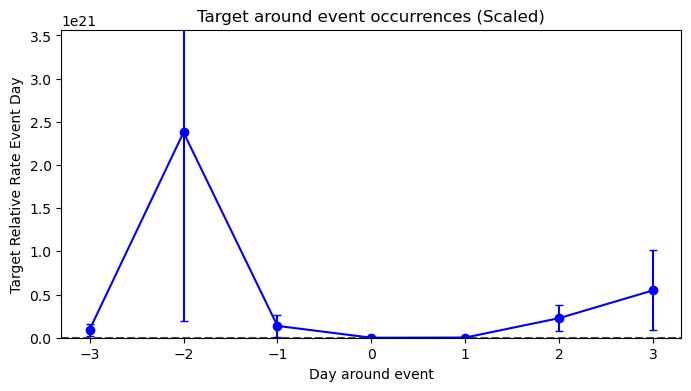

In [7385]:
# 계산 편리를 위한 인덱스 초기화 
date_index = test_copy_df.index
test_copy_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_copy_df.index[test_copy_df['event_flag'] == 1]


# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}


# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_copy_df):  # 인덱스 범위 체크
            event_data[day].append(test_copy_df.loc[target_idx, 'target'])
    

test_copy_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE']) * 100

# 그래프 그리기
plt.figure(figsize=(8, 4))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around event")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around event occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


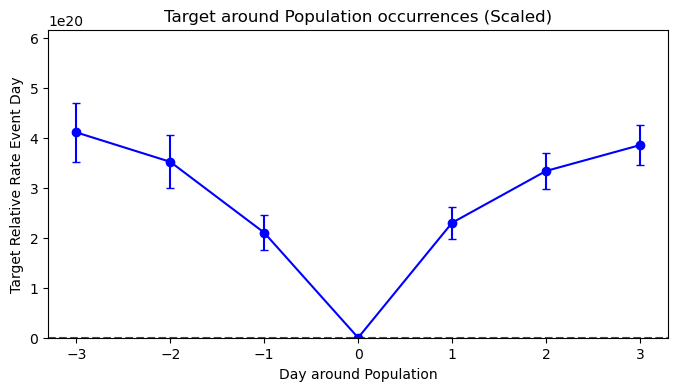

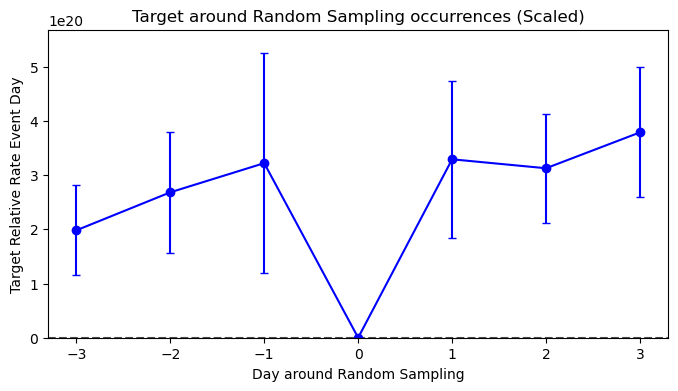

In [7386]:
### Population
# 계산 편리를 위한 인덱스 초기화 
date_index = test_copy_df.index
test_copy_df.reset_index(drop=True, inplace=True)


# 전체 인덱스 선택
event_indices = [i for i in range(3, len(test_copy_df) - 4)]


# # 100개의 랜덤 인덱스 선택
# num_samples = 150
# np.random.seed(13)
# event_indices = np.random.randint(3, len(test_copy_df) - 4, size=num_samples)
# event_indices = list(set(event_indices))

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_copy_df):  # 인덱스 범위 체크
            event_data[day].append(test_copy_df.loc[target_idx, 'target'])

test_copy_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE']) * 100

# 그래프 그리기
plt.figure(figsize=(8, 4))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around Population")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around Population occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 랜덤 샘플링했을때 Event Day보다 다른 날짜의 Mean이 큰 이유는 저렇게 잡았을 때 Event 날 Transaction이 클 경우보다
### 그 주변 날짜에 Transaction이 큰 날이 들어갈 확률이 높기 때문이다.


##### Random Sampling
#### 
# 계산 편리를 위한 인덱스 초기화 
date_index = test_copy_df.index
test_copy_df.reset_index(drop=True, inplace=True)


# 100개의 랜덤 인덱스 선택
num_samples = 150
np.random.seed(13)
event_indices = np.random.randint(3, len(test_copy_df) - 4, size=num_samples)
event_indices = list(set(event_indices))

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_copy_df):  # 인덱스 범위 체크
            event_data[day].append(test_copy_df.loc[target_idx, 'target'])

test_copy_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE']) * 100

# 그래프 그리기
plt.figure(figsize=(8, 4))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around Random Sampling")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around Random Sampling occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 랜덤 샘플링했을때 Event Day보다 다른 날짜의 Mean이 큰 이유는 저렇게 잡았을 때 Event 날 Transaction이 클 경우보다
### 그 주변 날짜에 Transaction이 큰 날이 들어갈 확률이 높기 때문이다.


#### Population이 저렇게 나오는 이유
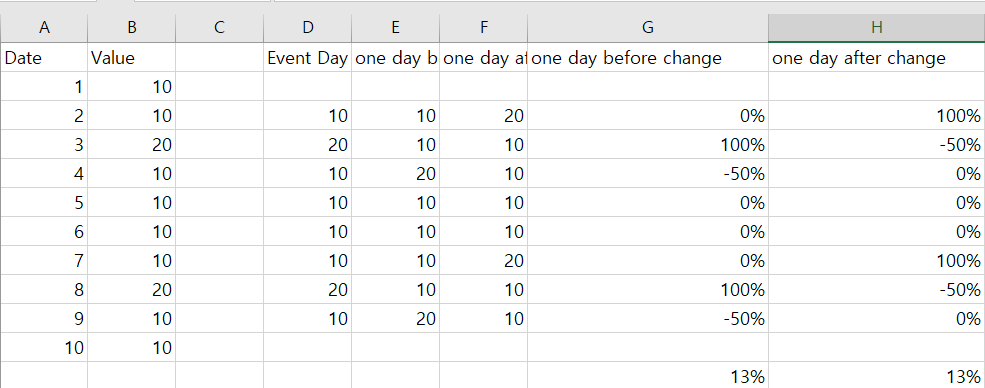

In [7387]:
test_copy_df['target_delta'] = test_copy_df['target'].diff()

# 계산 편리를 위한 인덱스 초기화 
date_index = test_copy_df.index
test_copy_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_copy_df.index[test_copy_df['event_flag'] == 1]


# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}


# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_copy_df):  # 인덱스 범위 체크
            event_data[day].append(test_copy_df.loc[target_idx, 'target_delta'])
    

test_copy_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)

event_cal_df = event_cal_df.fillna(event_cal_df.mean())


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

baseline = event_transaction_df[event_transaction_df['Day'] == 0]['Mean'].values[0]  # 0일 기준
# se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
# event_transaction_df['SE Change (%)'] = ((event_transaction_df['SE']) / se_baseline)

event_transaction_df

# # 그래프 그리기
# plt.figure(figsize=(8, 4))
# # plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
# #              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=0, fmt='-o', color='blue', capsize=3)

# plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
# plt.xlabel("Day around event")
# plt.ylabel("Target Relative Rate Event Day")
# plt.title("Target around event occurrences (Scaled)")

# plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

# plt.show()



c:\Users\slaye\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,Day,Mean,SE,Relative Change (%)
0,-3,-inf,NaN,-inf
1,-2,NaN,NaN,NaN
2,-1,-inf,NaN,-inf
3,0,0.0,0.0,0.0
4,1,inf,NaN,inf
5,2,inf,NaN,inf
6,3,NaN,NaN,NaN


### 백테스팅

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\3750366802.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_target = plot_target/plot_target[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\3750366802.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_price = plot_price/plot_price[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\3750366802.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(plot_ta

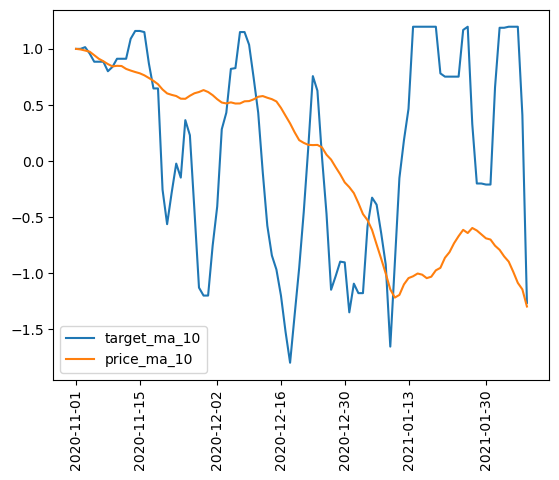

In [7388]:
### Target MA, Close MA 시각화
# 시간단위 분할
start = 1400
end = 1500

# Plot 용도 변수
plot_target = test_df.target
plot_target = plot_target/plot_target[0]
plot_price = test_df.close
plot_price = plot_price/plot_price[0]
plot_returns = test_df.returns
plot_target_returns = test_df.target_returns

# Moving Average 계산
plot_target_ma_10 = plot_target.rolling(5).mean().fillna(plot_target.mean())
plot_price_ma_10 = plot_price.rolling(5).mean().fillna(plot_target.mean())


# # 그래프 찍어보기
# plt.plot(plot_target[start:end]/plot_target[start]/100, label='target')
# plt.plot(plot_price[start:end], label='price')
plt.plot(plot_target_ma_10[start:end]/plot_target_ma_10[start], label='target_ma_10')
plt.plot(plot_price_ma_10[start:end]/plot_price_ma_10[start], label='price_ma_10')
# plt.plot(plot_returns[start:end], label='returns')
# plt.plot(plot_target_returns[start:end]/30, label='target_returns)
plt.xticks(rotation=90)
plt.legend()

# x축 자동으로 적절한 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  

plt.show()

### 백테스팅용 파생변수 생성 (Trading Flag...)
Transaction amount를 이용해 Trading Flag 생성

In [7389]:
### 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")

### target df 읽기
columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_receive.csv")
target_event_send_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_send.csv")

target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_send_df = preprocess_transaction_flag(target_event_send_df)

target_event_receive_df.columns = columns
target_event_send_df.columns = columns

### target difference df
target_event_difference_df = target_event_receive_df.copy()
target_event_difference_df['transaction_count'] = (target_event_receive_df['transaction_count'] - target_event_send_df['transaction_count'])
target_event_difference_df['transaction_amount'] = (target_event_receive_df['transaction_amount'] - target_event_send_df['transaction_amount'])
target_event_difference_df['transaction_flag'] = target_event_difference_df['transaction_amount'].apply(
    lambda x: 1 if x > 0 else (0 if x == 0 else -1)
)

### 날짜에 맞춰 자르기
start = (test_df['date'].values)[0]
end = (test_df['date'].values)[-1]

target_event_receive_df = trim_date(target_event_receive_df, start, end)
target_event_send_df = trim_date(target_event_send_df, start, end)
target_event_difference_df = trim_date(target_event_difference_df, start, end)

test_df.set_index('date', inplace=True)



### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'

event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)
test_df['big_returns_flag'] = test_df['returns'].abs()>0.05
# test_df['lag_event_flag'] = test_df['event_flag'].shift(-2).fillna(0)
event_flag_copy = test_df['event_flag'].values
big_returns_flag_copy = test_df['big_returns_flag'].values

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

### 회귀분석 돌릴때 Cheating 방지용으로 transaction 관련 target값 삭제
transaction_count = test_df['transaction_count'].copy()
transaction_amount = test_df['transaction_amount'].copy()
transaction_amount_usd = test_df['transaction_amount_usd'].copy()

### 수익률 관련 변수
returns_copy = test_df['returns'].copy()
test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())
during_2day_copy = test_df['returns_during_2day'].values


##### 전처리 관련
### 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)

### NaN값 처리 방법
test_df = test_df.fillna(test_df.mean())

### test_df 나중 분석을 위해 따로 저장
test_copy_df = test_df.copy()

### 스케일링
scaler = StandardScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

test_df = test_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag', 'transaction_amount_usd'], axis=1)

# test_df['target_delta'] = test_df['target'].diff(1)

### 스케일링 유의 변수
test_df['returns'] = returns_copy
test_df['returns_during_2day'] = during_2day_copy
test_df['event_flag'] = event_flag_copy
test_df['big_returns_flag'] = big_returns_flag_copy

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\451573566.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)
C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\451573566.py:98: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())


In [7390]:
### test_df에 target_df 데이터 적용
test_copy_df['transaction_count'] = target_df['transaction_count']
test_copy_df['transaction_amount'] = target_df['transaction_amount']
test_copy_df['transaction_flag'] = target_df['transaction_flag']
test_copy_df['transaction_amount_usd'] = test_copy_df['transaction_amount'] * test_copy_df['close']

# trading flag 생성
test_copy_df['transaction_amount_returns'] = test_copy_df['transaction_amount_usd'].pct_change(1).fillna(test_copy_df.mean())
threshold = 0
test_copy_df['transaction_amount_trading_flag'] = test_copy_df['transaction_amount_returns'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else (-1 if x == np.inf else 0)))
test_copy_df['transaction_amount_trading_reversion'] = test_copy_df['transaction_amount_returns'].apply(lambda x: -1 if x > 0 else (1 if x < -0 else 0))

# 지연 수익률 계산, carrying 수익률 
test_copy_df['returns'] = test_copy_df['close'].pct_change(1).fillna(test_copy_df.mean())
test_copy_df['returns_after_1day'] = test_copy_df['returns'].shift(-1).fillna(test_copy_df.mean())
test_copy_df['returns_after_2day'] = test_copy_df['returns'].shift(-2).fillna(test_copy_df.mean())
test_copy_df['returns_after_3day'] = test_copy_df['returns'].shift(-3).fillna(test_copy_df.mean())
test_copy_df['returns_during_2day'] = test_copy_df['close'].pct_change(2).shift(-2).fillna(test_copy_df.mean())
test_copy_df['returns_during_3day'] = test_copy_df['close'].pct_change(3).shift(-3).fillna(test_copy_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_copy_df = test_copy_df.replace([np.inf, -np.inf], np.nan)
test_copy_df = test_copy_df.fillna(test_copy_df.mean())


# check test df 날짜 인덱싱
check_test_df = test_copy_df.copy()
check_test_df = check_test_df[check_test_df.index>='2023-01-01']

# Scaling, Weighted Return 파생변수 생성
check_test_df['scaled_transaction_amount'] = (check_test_df['transaction_amount']-check_test_df['transaction_amount'].min()) / (check_test_df['transaction_amount'].max()-check_test_df['transaction_amount'].min())
check_test_df['transaction_amount_weight_returns'] = check_test_df['scaled_transaction_amount'] * check_test_df['returns']
check_test_df['lag_reversion_returns'] = check_test_df['transaction_amount_trading_reversion'] * check_test_df['returns_after_1day']

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'].apply(lambda x: -x) # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\3762671956.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.38548432e-04 -1.09849285e-03 -4.17683098e-04  2.94433095e-03
  1.52751210e-02  5.03453664e-02  5.74845781e-02  1.50516254e-02
 -2.39973756e-03  7.57237589e-02  5.13252403e-03 -1.23736443e-02
  1.89127416e-02 -2.23453421e-03  3.12605874e-02 -3.85872472e-02
  1.30981353e-02 -1.02693925e-02 -1.68874138e-02 -7.42993366e-03
  2.09967965e-02 -5.08056439e-02 -4.39322534e-04  1.95586749e-02
  4.47428577e-02  2.52259160e-03 -1.46228780e-02  2.35022100e-02
 -1.00077702e-02 -3.15331534e-02 -1.21715105e-03 -1.49207669e-02
 -6.92582030e-03  3.74419877e-03 -9.02353252e-04 -9.46184739e-03
 -1.03883565e-02  1.51379432e-02  2.30962101e-02  2.93638303e-02
  9.58586779e-02 -9.14671966e-03  3.83267091e-02 -2.97200147e-02
  1.83920518e-02 -3.01465422e-02  5.01974016e-03 -1.12905046e-02
 -9.87110903e-03 -1.320

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\870813761.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])


sharpe ratio:  1.5091121879521623
cumulative returns:  3.828198447625503
MDD:  -0.26151375053867665


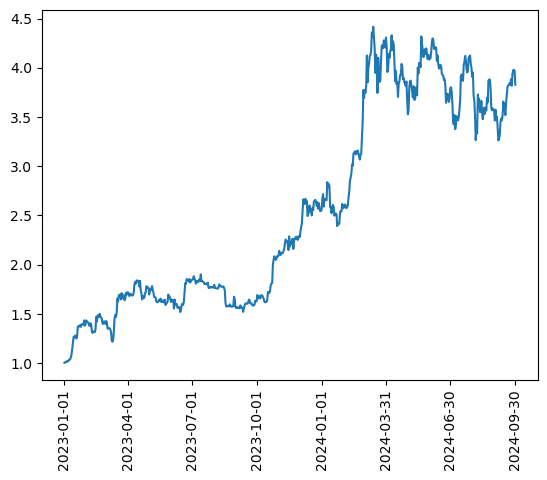

sharpe ratio:  1.6498944819401322
cumulative returns:  3.091020134574881
MDD:  -0.1590650881619918


C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\870813761.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])


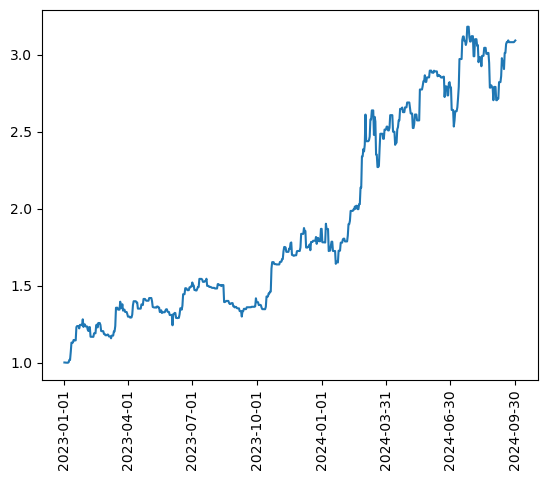

In [7391]:
# # 각 전략, 수익률별 그래프 및 지표
# # transaction weighted average returns
# plt.plot((check_test_df.transaction_amount_weight_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.transaction_amount_weight_returns.mean()/check_test_df.transaction_amount_weight_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.transaction_amount_weight_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.transaction_amount_weight_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.show()


# # lag_reversion_returns
# plt.plot((check_test_df.lag_reversion_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.lag_reversion_returns.mean()/check_test_df.lag_reversion_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.lag_reversion_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.lag_reversion_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.show()


# trading 없이 비교
plt.plot((check_test_df.returns+1).cumprod())
print('sharpe ratio: ', check_test_df.returns.mean()/check_test_df.returns.std()*np.sqrt(252))
print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((check_test_df.returns+1).cumprod()))
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()

# # 1일 뒤 returns (1 day carrying)
# plt.plot((trading_price_df['returns_after_1day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_after_1day'].mean()/trading_price_df['returns_after_1day'].std()*np.sqrt(252))
# # trading 없이 비교
# plt.plot((check_test_df['returns']+1).cumprod())
# print('sharpe ratio: ', check_test_df['returns'].mean()/check_test_df['returns'].std()*np.sqrt(252))
# plt.show()

# 2일 뒤 returns (2 day after returns)
plt.plot((check_test_df.adjusted_returns+1).cumprod())
print('sharpe ratio: ', check_test_df.adjusted_returns.mean()/check_test_df.adjusted_returns.std()*np.sqrt(252))
print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((check_test_df.adjusted_returns+1).cumprod()))
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()

# # 2일 뒤 returns (2 day after returns)
# plt.plot((trading_price_df['returns_after_2day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_after_2day'].mean()/trading_price_df['returns_after_2day'].std()*np.sqrt(252))

# # 2일 동안 returns (2 day carrying)
# plt.plot((trading_price_df['returns_during_2day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_during_2day'].mean()/trading_price_df['returns_during_2day'].std()*np.sqrt(252))

### Target Amount Quantile 나눠서 백테스팅

C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\948250905.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01296866 -0.01720142  0.0059761  ...  0.00176095  0.00176095
  0.00176095]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지


Sharpe Ratio (Carrying):  0.6897221943015123
Cumulative Returns (Carrying):  14.804455695233935
MDD (Carrying):  -0.87170027527068
Sharpe Ratio (With Trading Flag):  0.8295620255910696
Cumulative Returns (With Trading Flag):  40.10400112477448
MDD (With Trading Flag):  -0.7968569669895655


C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\948250905.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Carrying): ', (check_test_df.returns + 1).cumprod()[-1])
C:\Users\slaye\AppData\Local\Temp\ipykernel_35368\948250905.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (With Trading Flag): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])


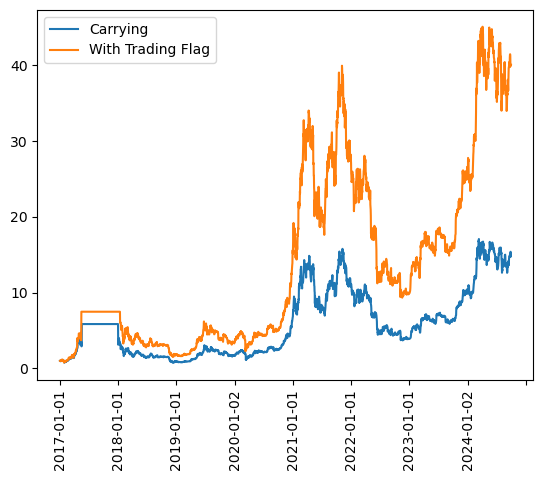

In [7392]:
### test_df에 target_df 데이터 적용
test_copy_df['transaction_count'] = target_df['transaction_count']
test_copy_df['transaction_amount'] = target_df['transaction_amount']
test_copy_df['transaction_flag'] = target_df['transaction_flag']
test_copy_df['transaction_amount_usd'] = test_copy_df['transaction_amount'] * test_copy_df['close']

# check test df 날짜 인덱싱
check_test_df = test_copy_df.copy()
check_test_df = check_test_df[check_test_df.index>='2017-01-01']

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).shift(-1).fillna(check_test_df.mean())

# threshold = 0.1
# # 거래량 상위 5% 임계값 설정
# upper_threshold = check_test_df['transaction_amount'].quantile(1-threshold)
# lower_threshold = check_test_df['transaction_amount'].quantile(threshold)
# check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount'].apply(lambda x: 1 if x >= upper_threshold else (-1 if x <= lower_threshold else (-1 if x == np.inf else 0)))

threshold = check_test_df['transaction_amount_usd'].quantile(0.97)
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_usd'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률 
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_1day'] = check_test_df['returns'].shift(-1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())

# Scaling, Weighted Return 파생변수 생성
check_test_df['scaled_transaction_amount'] = (check_test_df['transaction_amount']-check_test_df['transaction_amount'].min()) / (check_test_df['transaction_amount'].max()-check_test_df['transaction_amount'].min())
check_test_df['transaction_amount_weight_returns'] = check_test_df['scaled_transaction_amount'] * check_test_df['returns']
check_test_df['lag_reversion_returns'] = check_test_df['transaction_amount_trading_reversion'] * check_test_df['returns_after_1day']

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'].apply(lambda x: -x) # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# # trading 없이 비교
# plt.plot((check_test_df.returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.returns.mean()/check_test_df.returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

# # 2일 뒤 returns (2 day after returns)
# plt.plot((check_test_df.adjusted_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.adjusted_returns.mean()/check_test_df.adjusted_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.adjusted_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

plt.plot((check_test_df.returns + 1).cumprod(), label='Carrying')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='With Trading Flag')

print('Sharpe Ratio (Carrying): ', check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252))
print('Cumulative Returns (Carrying): ', (check_test_df.returns + 1).cumprod()[-1])
print('MDD (Carrying): ', calculate_mdd((check_test_df.returns + 1).cumprod()))

print('Sharpe Ratio (With Trading Flag): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Cumulative Returns (With Trading Flag): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (With Trading Flag): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()


### Custom Returns Check

In [7393]:
### Returns의 기본적인 평균값
print("The mean of returns:", test_copy_df['returns'].mean())


### 만약 상위 1% threshold를 넘기면?
threshold = test_copy_df.target.quantile(0.99)
returns_check_df = test_copy_df[test_copy_df['target']>=threshold]
print("The mean of Top 1% returns:", returns_check_df['returns_after_3day'].mean())

### 만약 하위 1% threshold를 넘기면?
threshold = test_copy_df.target.quantile(0.01)
returns_check_df = test_copy_df[test_copy_df['target']<=threshold]
print("The mean of Bottom 1% returns:", returns_check_df['returns_after_2day'].mean())

The mean of returns: 0.001747848142226556
The mean of Top 1% returns: -0.012996536484602424
The mean of Bottom 1% returns: 0.0063179081554285196


In [7394]:
### During 2 days의 기본적인 평균값
print("The mean of returns:", test_copy_df['returns_during_2day'].mean())


### 만약 상위 1% threshold를 넘기면?
threshold = test_copy_df.target.quantile(0.99)
returns_check_df = test_copy_df[test_copy_df['target']>=threshold]
print("The mean of Top 1% returns:", returns_check_df['returns_during_2day'].mean())

### 만약 하위 1% threshold를 넘기면?
threshold = test_copy_df.target.quantile(0.01)
returns_check_df = test_copy_df[test_copy_df['target']<=threshold]
print("The mean of Bottom 1% returns:", returns_check_df['returns_during_2day'].mean())

The mean of returns: 0.0034761099831929886
The mean of Top 1% returns: -0.01407071342656633
The mean of Bottom 1% returns: 0.010804024530239764


In [7395]:
test_copy_df['returns_during_3day'].mean()

0.00521905678927385

In [7396]:
threshold = test_copy_df.target.quantile(0.01)
returns_check_df = test_copy_df[test_copy_df['target']<=threshold]
returns_check_df['returns_during_3day'].mean()

0.023830265026681487

In [7397]:
threshold = test_copy_df.target_delta.quantile(0.95)
returns_check_df = test_copy_df[test_copy_df['target_delta']>=threshold]
returns_check_df['returns_after_3day'].mean()

0.011475028913338955

In [7398]:
threshold = test_copy_df.target_delta.quantile(0.05)
returns_check_df = test_copy_df[test_copy_df['target_delta']<=threshold]
returns_check_df['returns_after_3day'].mean()

-0.00550036148855747

In [7399]:
test_copy_df['target_delta']

date
2017-01-01   -2.363036e+07
2017-01-02   -2.710096e+09
2017-01-03    9.814528e+09
2017-01-04    8.930880e+08
2017-01-05   -6.771455e+09
                  ...     
2024-09-26    1.019123e+08
2024-09-27    7.903691e+08
2024-09-28    1.116831e+08
2024-09-29   -5.254446e+08
2024-09-30   -1.013343e+09
Name: target_delta, Length: 2830, dtype: float64

In [7400]:
threshold = 0
returns_check_df = test_copy_df[test_copy_df['target_delta']<=threshold]
returns_check_df['returns_after_3day'].mean()

0.0008993356354004775

In [7401]:
threshold = 0
returns_check_df = test_copy_df[test_copy_df['target_delta']>=threshold]
returns_check_df['returns_after_3day'].mean()

0.002864178330824123

In [7402]:
returns_check_df['returns_after_3day']

date
2017-01-03    0.005976
2017-01-04    0.018319
2017-01-06   -0.008186
2017-01-07    0.013260
2017-01-10    0.045773
                ...   
2024-09-24    0.009144
2024-09-25    0.001339
2024-09-26   -0.003887
2024-09-27   -0.034670
2024-09-28    0.001761
Name: returns_after_3day, Length: 1241, dtype: float64

### 왜